In [16]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

SEED=42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [17]:
# 경로 설정
DATA_DIR="../../../data/processed/04_processed_data/images"
LABEL_CSV="../../../data/processed/04_processed_data/all_labels.csv"
RESULT_DIR="../../../src/results"
os.makedirs(RESULT_DIR, exist_ok=True)

# 기타 설정
BATCH_SIZE=16
IMAGE_SIZE=(224, 224)
LABEL_COLS=["male","female","0s","10s","20s","30s","40s","50s","60+"]

In [18]:
df=pd.read_csv(LABEL_CSV)
train_df, test_df=train_test_split(df, test_size=0.1, random_state=SEED, shuffle=True)
train_df, val_df=train_test_split(train_df, test_size=0.1, random_state=SEED, shuffle=True)

print(train_df.shape, val_df.shape, test_df.shape)

(20910, 10) (2324, 10) (2582, 10)


In [19]:
class AgeSexDataset(Dataset):
    def __init__(self, image_dir, dataframe, transform=None):
        self.image_dir=image_dir
        self.dataframe=dataframe.reset_index(drop=True)
        self.transform=transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path=os.path.join(self.image_dir, self.dataframe.loc[idx, "filename"])
        image=Image.open(img_path).convert("RGB")
        label=self.dataframe.loc[idx, LABEL_COLS].values.astype(np.float32)

        if self.transform:
            image=self.transform(image)

        return image, torch.tensor(label)

In [ ]:
transform=transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor()
])

train_dataset=AgeSexDataset(DATA_DIR, train_df, transform)
val_dataset=AgeSexDataset(DATA_DIR, val_df, transform)
test_dataset=AgeSexDataset(DATA_DIR, test_df, transform)

train_loader=DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader=DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader=DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [21]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS=20
LR=1e-3

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features=nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.classifier=nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * (IMAGE_SIZE[0]//8) * (IMAGE_SIZE[1]//8), 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x=self.features(x)
        x=self.classifier(x)
        return x

model=SimpleCNN(num_classes=len(LABEL_COLS)).to(device)
loss_function=nn.BCEWithLogitsLoss()
optimizer=optim.Adam(model.parameters(), lr=LR)

In [22]:
train_loss_list=[]
val_loss_list=[]
train_acc_list=[]
val_acc_list=[]

best_val_loss=float("inf")

for epoch in range(EPOCHS):
    model.train()
    train_loss=0
    correct_train=0
    total_train=0

    for images, labels in train_loader:
        images, labels=images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs=model(images)
        loss=loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()
        preds=torch.sigmoid(outputs)>0.5
        correct_train+=(preds.cpu()==labels.cpu()).all(dim=1).sum().item()
        total_train+=labels.size(0)

    avg_train_loss=train_loss/len(train_loader)
    train_acc=correct_train/total_train

    model.eval()
    val_loss=0
    correct_val=0
    total_val=0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels=images.to(device), labels.to(device)
            outputs=model(images)
            loss=loss_function(outputs, labels)
            val_loss+=loss.item()
            preds=torch.sigmoid(outputs)>0.5
            correct_val+=(preds.cpu()==labels.cpu()).all(dim=1).sum().item()
            total_val+=labels.size(0)

    avg_val_loss=val_loss/len(val_loader)
    val_acc=correct_val/total_val

    train_loss_list.append(avg_train_loss)
    val_loss_list.append(avg_val_loss)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)

    print(f"Epoch [{epoch+1}/{EPOCHS}] Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss<best_val_loss:
        best_val_loss=avg_val_loss
        torch.save(model.state_dict(), os.path.join(RESULT_DIR, "06_best_model.pth"))

Epoch [1/20] Train Loss: 0.3274, Val Loss: 0.2282
Epoch [2/20] Train Loss: 0.2176, Val Loss: 0.1778
Epoch [3/20] Train Loss: 0.1650, Val Loss: 0.1445
Epoch [4/20] Train Loss: 0.1297, Val Loss: 0.1252
Epoch [5/20] Train Loss: 0.1051, Val Loss: 0.1122
Epoch [6/20] Train Loss: 0.0853, Val Loss: 0.1176
Epoch [7/20] Train Loss: 0.0710, Val Loss: 0.1062
Epoch [8/20] Train Loss: 0.0640, Val Loss: 0.1044
Epoch [9/20] Train Loss: 0.0560, Val Loss: 0.1229
Epoch [10/20] Train Loss: 0.0501, Val Loss: 0.1137
Epoch [11/20] Train Loss: 0.0464, Val Loss: 0.1137
Epoch [12/20] Train Loss: 0.0421, Val Loss: 0.1141
Epoch [13/20] Train Loss: 0.0415, Val Loss: 0.1161
Epoch [14/20] Train Loss: 0.0381, Val Loss: 0.1181
Epoch [15/20] Train Loss: 0.0352, Val Loss: 0.1179
Epoch [16/20] Train Loss: 0.0328, Val Loss: 0.1420
Epoch [17/20] Train Loss: 0.0327, Val Loss: 0.1533
Epoch [18/20] Train Loss: 0.0301, Val Loss: 0.1465
Epoch [19/20] Train Loss: 0.0293, Val Loss: 0.1455
Epoch [20/20] Train Loss: 0.0274, Val Lo

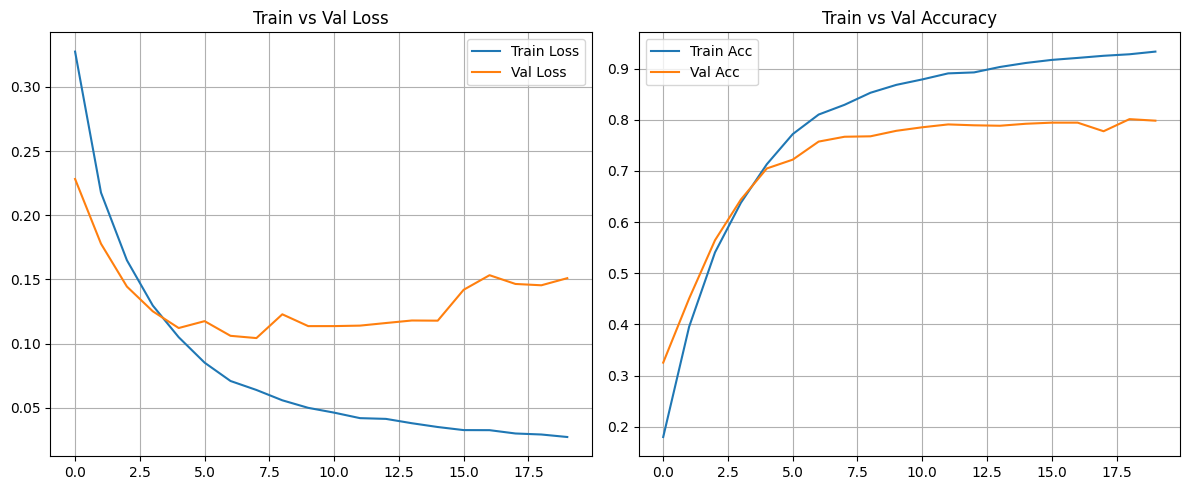

In [23]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_loss_list, label="Train Loss")
plt.plot(val_loss_list, label="Val Loss")
plt.title("Train vs Val Loss")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_acc_list, label="Train Acc")
plt.plot(val_acc_list, label="Val Acc")
plt.title("Train vs Val Accuracy")
plt.grid()
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(RESULT_DIR, "06_acc_loss_graph.jpg"))
plt.show()

In [24]:
model.load_state_dict(torch.load(os.path.join(RESULT_DIR, "06_best_model.pth")))
model.eval()

all_images=[]
all_labels=[]
all_preds=[]

with torch.no_grad():
    for images, labels in test_loader:
        images=images.to(device)
        outputs=model(images)
        preds=torch.sigmoid(outputs).cpu().numpy()

        all_images.extend(images.cpu())
        all_labels.extend(labels.numpy())

        sex_preds=preds[:, :2]
        sex_argmax=np.argmax(sex_preds, axis=1)
        sex_result=np.zeros_like(sex_preds)
        sex_result[np.arange(len(sex_preds)), sex_argmax]=1

        age_preds=preds[:, 2:]
        age_argmax=np.argmax(age_preds, axis=1)
        age_result=np.zeros_like(age_preds)
        age_result[np.arange(len(age_preds)), age_argmax]=1

        clean_preds=np.concatenate([sex_result, age_result], axis=1)
        all_preds.extend(clean_preds)

all_labels=np.array(all_labels)
all_preds=np.array(all_preds)

report=classification_report(all_labels, all_preds, target_names=LABEL_COLS, digits=4)
print(report)
with open(os.path.join(RESULT_DIR, "06_classification_report.txt"), "w") as f:
    f.write(report)

              precision    recall  f1-score   support

        male     0.9687    0.9911    0.9797      1341
      female     0.9901    0.9654    0.9776      1241
          0s     0.9651    0.9945    0.9796       362
         10s     0.8922    0.9350    0.9131       354
         20s     0.8801    0.8005    0.8384       376
         30s     0.7953    0.9210    0.8535       367
         40s     0.7216    0.6829    0.7017       391
         50s     0.7358    0.7096    0.7225       365
         60+     0.9140    0.8692    0.8911       367

   micro avg     0.9105    0.9105    0.9105      5164
   macro avg     0.8737    0.8743    0.8730      5164
weighted avg     0.9105    0.9105    0.9098      5164
 samples avg     0.9105    0.9105    0.9105      5164



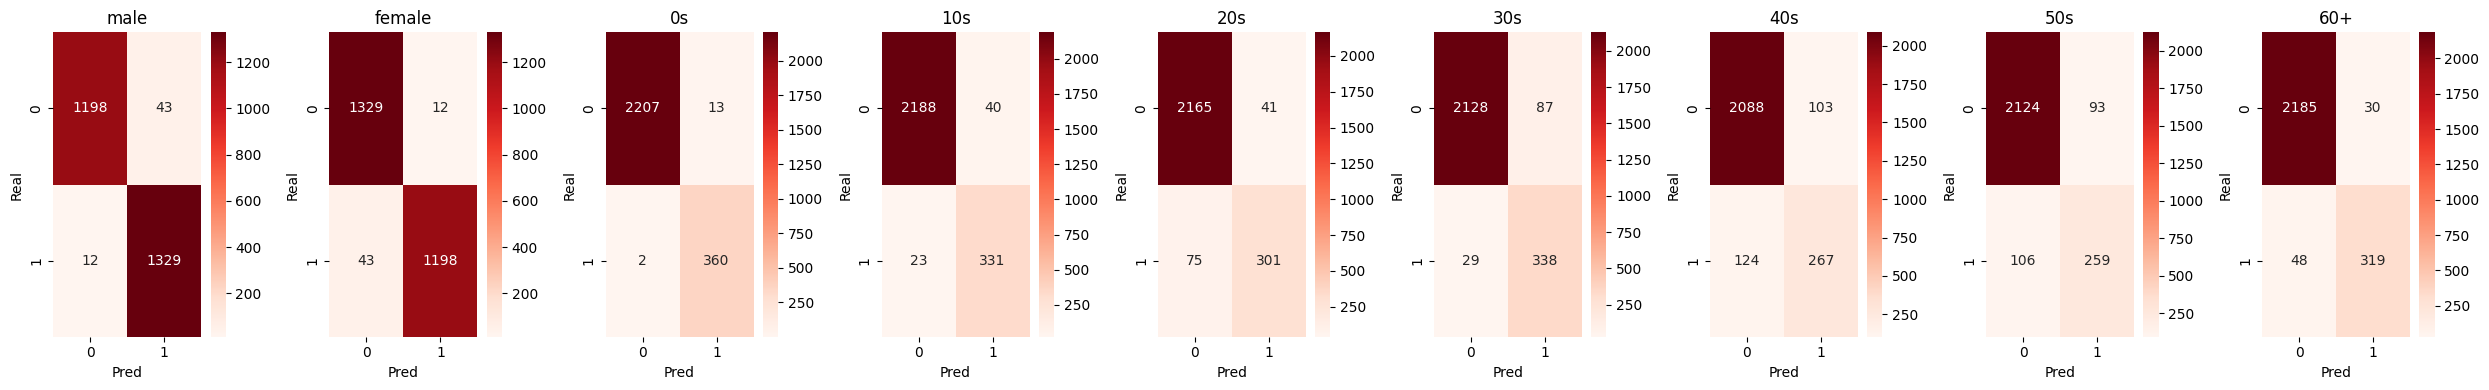

In [25]:
fig, axes=plt.subplots(1, len(LABEL_COLS), figsize=(25,4))

for i, label_name in enumerate(LABEL_COLS):
    cm=confusion_matrix(all_labels[:,i], all_preds[:,i])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", ax=axes[i])
    axes[i].set_title(label_name)
    axes[i].set_xlabel("Pred")
    axes[i].set_ylabel("Real")

plt.tight_layout()
plt.savefig(os.path.join(RESULT_DIR, "06_confusion_matrix.jpg"))
plt.show()

In [ ]:
random.seed(SEED)
indices=random.sample(range(len(all_images)), 10)

plt.figure(figsize=(20,8))
for i, idx in enumerate(indices):
    img=all_images[idx].permute(1,2,0).numpy()
    real_label=all_labels[idx].astype(int)
    pred_label=all_preds[idx].astype(int)

    real_text=[LABEL_COLS[j] for j,v in enumerate(real_label) if v==1]
    pred_text=[LABEL_COLS[j] for j,v in enumerate(pred_label) if v==1]

    plt.subplot(2,5,i+1)
    plt.imshow(img)
    plt.title(f"Real: {real_text}\nPred: {pred_text}")
    plt.axis("off")

plt.tight_layout()
plt.savefig(os.path.join(RESULT_DIR, "06_sample_predictions.jpg"))
plt.show()